In [1]:
# Global imports
import os
import numpy as np
import pandas as pd
import imageio
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, LeakyReLU, MaxPooling2D, Flatten, Dense
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import tensorflow_addons as tfa
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from sklearn.model_selection import KFold
import numpy as np
import os
import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, LeakyReLU, Flatten, Dense
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
from tqdm import tqdm
import gc

c:\Users\herna\anaconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\herna\anaconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want

In [2]:
import tensorflow as tf
import librosa
#print(tf.config.list_physical_devices('GPU'))
# Desactivar GPU y forzar uso de CPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        #tf.config.experimental.set_memory_growth(gpus[0], True)
        pass
    except RuntimeError as e:
        print(e)

#tf.config.set_visible_devices([], 'GPU')

# Load dataset


In [3]:
import pickle
def load_data(filename):
    """
    Load data from a pickle file.

    Args:
        filename (str): The path to the pickle file.

    Returns:
        dict: The loaded data dictionary.
    """
    with open(filename, 'rb') as file:
        data_dict_loaded = pickle.load(file)
    return data_dict_loaded

filename = "../Data/D3TEC.pkl"
data_dict_loaded = load_data(filename)
# data_dict_loaded

In [4]:
data_dict_loaded[3]

{'Marca temporal': '2023/10/11 1:57:08 p.\xa0m. GMT-6',
 'PHQ-9 Score': 3,
 'Age': 62,
 'Gender': 'Female',
 'Lugar de Residencia': 'San Pedro, Nuevo León',
 'Lugar de Procedencia': nan,
 'Social Class': 'Upper Class',
 'Institution': 'CAABI',
 'Medicine': 'Sertrialina',
 'Physical Condition': 'Estenosis Espinal',
 'Mental Health Condition': 'Ansiedad',
 'Depression Diagnosis (level)': nan,
 'PHQ-Binary': 0,
 'audios': {'sm': {0: {'file_path': 'D:/Github/Improving-deep-neural-networks-to-identify-mental-disorders-using-Neural-Architecture-Search/D3T3C/D3TEC Dataset/SM-27\\153.wav',
    'waveform': array([-3.4575351e-07, -3.7821010e-06, -4.8473012e-06, ...,
           -7.4757336e-06, -4.6938076e-06, -1.4753023e-06], dtype=float32),
    'sample_rate': 22050,
    'spectrogram': array([[-41.41863 , -35.586212, -42.963806, ..., -50.34841 , -42.829468,
            -59.43257 ],
           [-42.578403, -34.543472, -38.21392 , ..., -37.266647, -38.4431  ,
            -47.42988 ],
           [-4

In [5]:
def generate_image_from_spectrogram(spectrogram):
    global first_call
    fig, ax = plt.subplots(figsize=(7.92, 2.52))  # Ajustar tamaño de figura a 792x252 píxeles
    img = librosa.display.specshow(spectrogram, x_axis='time', y_axis='mel', ax=ax)
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Ajustar los márgenes
    ax.margins(0)
    ax.set_axis_off()
    plt.axis('off')  # Turn off axis labels

    if first_call:
        plt.show()
        first_call = False

    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0, transparent=True)
    buf.seek(0)
    img = Image.open(buf).convert('RGB')  # Convertir a RGB para eliminar el canal alfa
    img_array = np.array(img.resize((792, 252)))  # Asegurar tamaño de imagen
    plt.close(fig)

    return img_array

In [6]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_dict, batch_size):
        self.data_dict = data_dict
        self.keys = list(data_dict.keys())
        self.batch_size = batch_size
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.data_dict) / self.batch_size))

    def __getitem__(self, index):
        batch_keys = self.keys[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(batch_keys)
        return X, y

    def on_epoch_end(self):
        np.random.shuffle(self.keys)

    def __data_generation(self, batch_keys):
        X = []
        y = []
        for key in batch_keys:
            info = self.data_dict[key]
            for audio_type, audios in info['audios'].items():
                for question_number, audio_data in audios.items():
                    if isinstance(question_number, int):  # Ensure it is a question number
                        spectrogram = audio_data['mel_spectrogram']
                        spectrogram_image = generate_image_from_spectrogram(spectrogram)
                        X.append(spectrogram_image)
                        y.append(info['PHQ-Binary'])
        X = np.array(X)
        y = np.array(y)
        X = X / 255.0  # Normalize the images
        X = np.expand_dims(X, axis=-1)  # Add channel dimension
        return X, y


In [7]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, LeakyReLU, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import KFold
import datetime
import json
from tqdm import tqdm
import librosa
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
import gc

# Variable global para rastrear si la función ya se ha llamado
first_call = True

def specificity(y_true, y_pred):
    true_negatives = tf.reduce_sum(tf.cast((y_pred < 0.5) & (y_true == 0), tf.float32))
    possible_negatives = tf.reduce_sum(tf.cast(y_true == 0, tf.float32))
    specificity = true_negatives / (possible_negatives + tf.keras.backend.epsilon())
    return specificity

class KFoldCNNTester:
    def __init__(self, data_dict, filename, batch_size=1, use_dummy_data=False):
        self.data_dict = data_dict
        self.filename = filename
        self.batch_size = batch_size
        self.mean_acc_per_fold = []
        self.mean_loss_per_fold = []
        self.mean_precision_per_fold = []
        self.mean_recall_per_fold = []
        self.mean_auc_per_fold = []
        self.mean_specificity_per_fold = []
        self.kfold_list = []
        self.state_file = f'{self.filename}_state.json'
        self.keys = list(data_dict.keys())  # Lista de keys del diccionario
        self.use_dummy_data = use_dummy_data

    def save_state(self, fold_no, epoch_no, num_folds):
        state = {'fold_no': fold_no, 'epoch_no': epoch_no, 'num_folds': num_folds}
        with open(self.state_file, 'w') as f:
            json.dump(state, f)

    def load_state(self):
        if os.path.exists(self.state_file):
            with open(self.state_file, 'r') as f:
                state = json.load(f)
            return state['fold_no'], state['epoch_no'], state['num_folds']
        return 1, 0, None

    def run_kfold_test(self):
        start_fold, start_epoch, start_num_folds = self.load_state()
        num_folds_range = [5, 8, 10] # range(3, 11)
        
        for num_folds in num_folds_range:
            if start_num_folds is not None and num_folds < start_num_folds:
                continue

            acc_per_fold = []
            loss_per_fold = []
            precision_per_fold = []
            recall_per_fold = []
            auc_per_fold = []
            specificity_per_fold = []

            no_epochs = 100
            verbosity = 2
            kfold = KFold(n_splits=num_folds, shuffle=True)

            fold_no = 1

            for train_indices, test_indices in kfold.split(range(len(self.data_dict))):
                if num_folds == start_num_folds and fold_no < start_fold:
                    fold_no += 1
                    continue

                # Obtener las keys correspondientes a los índices
                train_keys = [self.keys[i] for i in train_indices]
                test_keys = [self.keys[i] for i in test_indices]

                model = self.define_model()

                checkpoint_filepath_1 = f'{self.filename}_checkpoint_{num_folds}_fold_{fold_no}_1.h5'
                checkpoint_filepath_2 = f'{self.filename}_checkpoint_{num_folds}_fold_{fold_no}_2.h5'

                def try_load_weights():
                    try:
                        model.load_weights(checkpoint_filepath_1)
                    except Exception as e:
                        print(f"Error loading {checkpoint_filepath_1}: {e}")
                        try:
                            model.load_weights(checkpoint_filepath_2)
                        except Exception as e:
                            print(f"Error loading {checkpoint_filepath_2}: {e}")
                
                try_load_weights()

                print('------------------------------------------------------------------------')
                print(f'Training for fold {fold_no} of {num_folds} folds...')

                checkpoint_callback_1 = ModelCheckpoint(filepath=checkpoint_filepath_1, save_weights_only=True,
                                                        monitor='loss', mode='min', save_best_only=False)

                checkpoint_callback_2 = ModelCheckpoint(filepath=checkpoint_filepath_2, save_weights_only=True,
                                                        monitor='loss', mode='min', save_best_only=False)

                callback = EarlyStopping(monitor='loss', patience=3, min_delta=0.0001)

                for epoch in range(start_epoch, no_epochs):
                    for i in tqdm(range(0, len(train_keys), self.batch_size), desc=f"Training fold {fold_no}, epoch {epoch+1}"):
                        batch_keys = train_keys[i:i + self.batch_size]
                        X_train, y_train = self.generate_batch_data(batch_keys)
                        model.fit(X_train, y_train, batch_size=self.batch_size, epochs=1, verbose=verbosity, callbacks=[checkpoint_callback_1])
                        del X_train, y_train  # Eliminar datos del lote para liberar memoria
                        gc.collect()  # Recolector de basura explícito para liberar memoria

                    # Guardar el segundo checkpoint al finalizar la época
                    model.save_weights(checkpoint_filepath_2)

                    self.save_state(fold_no, epoch + 1, num_folds)
                    start_epoch = 0  # Reset start_epoch after the first epoch in this loop

                # Reset start_epoch for the next fold
                start_epoch = 0

                for i in tqdm(range(0, len(test_keys), self.batch_size), desc=f"Evaluating fold {fold_no}"):
                    batch_keys = test_keys[i:i + self.batch_size]
                    X_test, y_test = self.generate_batch_data(batch_keys)
                    scores = model.evaluate(X_test, y_test, verbose=0)
                    acc_per_fold.append(scores[1] * 100)
                    loss_per_fold.append(scores[0])
                    precision_per_fold.append(scores[2])
                    recall_per_fold.append(scores[3])
                    auc_per_fold.append(scores[4])
                    specificity_per_fold.append(scores[5])
                    del X_test, y_test  # Eliminar datos del lote para liberar memoria
                    gc.collect()  # Recolector de basura explícito para liberar memoria

                print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%; {model.metrics_names[2]}: {scores[2]}; {model.metrics_names[3]}: {scores[3]}; {model.metrics_names[4]}: {scores[4]}; {model.metrics_names[5]}: {scores[5]}')

                if scores[1] * 100 > 60:
                    self.save_model_and_data(model, fold_no, scores, num_folds, train_keys)

                self.save_state(fold_no + 1, 0, num_folds)  # Guardar el estado después de completar cada fold
                fold_no += 1

            self.calculate_means(acc_per_fold, loss_per_fold, precision_per_fold, recall_per_fold, auc_per_fold, specificity_per_fold, num_folds)

    def generate_batch_data(self, batch_keys):
        if self.use_dummy_data:
            X = np.random.rand(self.batch_size, 64, 64, 1)  # Datos dummy
            y = np.random.randint(0, 2, self.batch_size)  # Etiquetas dummy
        else:
            X = []
            y = []
            for key in batch_keys:
                info = self.data_dict[key]
                for audio_type, audios in info['audios'].items():
                    for question_number, audio_data in audios.items():
                        if isinstance(question_number, int):  # Ensure it is a question number
                            spectrogram = audio_data['mel_spectrogram']
                            spectrogram_image = generate_image_from_spectrogram(spectrogram)
                            X.append(spectrogram_image)
                            y.append(info['PHQ-Binary'])
            X = np.array(X)
            y = np.array(y)
            X = X / 255.0  # Normalize the images
            X = np.expand_dims(X, axis=-1)  # Add channel dimension
        return X, y

    def define_model(self):
        model = Sequential([
            BatchNormalization(name='batch_normalization_9'),
            Conv2D(16, kernel_size=(3, 3), padding='same', name='conv2d_6'),  # Reducir el número de filtros
            LeakyReLU(alpha=0.01, name='leaky_re_lu_9'),
            BatchNormalization(name='batch_normalization_10'),
            Conv2D(8, (3, 3), padding='same', name='conv2d_7'),
            LeakyReLU(alpha=0.01, name='leaky_re_lu_10'),
            BatchNormalization(name='batch_normalization_11'),
            Flatten(name='flatten_6'),
            Dense(32, name='dense_6'),  # Reducir el número de neuronas
            LeakyReLU(alpha=0.01, name='leaky_re_lu_11'),
            Dense(1, activation='sigmoid', name='dense_7')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC(), specificity])
        return model

    def save_model_and_data(self, model, fold_no, scores, num_folds, train_keys):
        current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        folder_path = f'{self.filename}_{current_time}/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        subfolder_path = folder_path + f'{num_folds}-fold_{fold_no}-{scores[1]*100}/'
        if not os.path.exists(subfolder_path):
            os.makedirs(subfolder_path)

        model.save(subfolder_path + f'fold-{fold_no}.h5')

    def calculate_means(self, acc_per_fold, loss_per_fold, precision_per_fold, recall_per_fold, auc_per_fold, specificity_per_fold, num_folds):
        mean_acc = sum(acc_per_fold) / len(acc_per_fold)
        mean_loss = sum(loss_per_fold) / len(loss_per_fold)
        mean_precision = sum(precision_per_fold) / len(precision_per_fold)
        mean_recall = sum(recall_per_fold) / len(recall_per_fold)
        mean_auc = sum(auc_per_fold) / len(auc_per_fold)
        mean_specificity = sum(specificity_per_fold) / len(specificity_per_fold)
        self.mean_acc_per_fold.append(mean_acc)
        self.mean_loss_per_fold.append(mean_loss)
        self.mean_precision_per_fold.append(mean_precision)
        self.mean_recall_per_fold.append(mean_recall)
        self.mean_auc_per_fold.append(mean_auc)
        self.mean_specificity_per_fold.append(mean_specificity)
        self.kfold_list.append(num_folds)

        current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        folder_path = f'{self.filename}_{current_time}_{num_folds}_mean/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        with open(folder_path + 'score.txt', 'a+') as file:
            file.write(f'accuracy: {mean_acc}. loss: {mean_loss}. precision: {mean_precision}. recall: {mean_recall}. auc: {mean_auc}. specificity: {mean_specificity}')

# Función para generar la imagen del espectrograma
def generate_image_from_spectrogram(spectrogram):
    global first_call
    fig, ax = plt.subplots(figsize=(7.92, 2.52))  # Ajustar tamaño de figura a 792x252 píxeles
    img = librosa.display.specshow(spectrogram, x_axis='time', y_axis='mel', ax=ax)
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Ajustar los márgenes
    ax.margins(0)
    ax.set_axis_off()
    plt.axis('off')  # Turn off axis labels
    
    if first_call:
        plt.show()
        first_call = False
    
    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0, transparent=True)
    buf.seek(0)
    img = Image.open(buf).convert('RGB')  # Convertir a RGB para eliminar el canal alfa
    img_array = np.array(img.resize((792, 252)))  # Asegurar tamaño de imagen
    plt.close(fig)
    
    return img_array


In [ ]:
# Crear una instancia de la clase con datos dummy
tester = KFoldCNNTester(data_dict_loaded, 'results_test', batch_size=2, use_dummy_data=True)

# Ejecutar el test K-Fold
tester.run_kfold_test()


Error loading results_checkpoint_5_fold_1_1.h5: Unable to load weights saved in HDF5 format into a subclassed Model which has not created its variables yet. Call the Model first, then load the weights.
Error loading results_checkpoint_5_fold_1_2.h5: Unable to load weights saved in HDF5 format into a subclassed Model which has not created its variables yet. Call the Model first, then load the weights.
------------------------------------------------------------------------
Training for fold 1 of 5 folds...


Training fold 1, epoch 1:   0%|          | 0/25 [00:00<?, ?it/s]

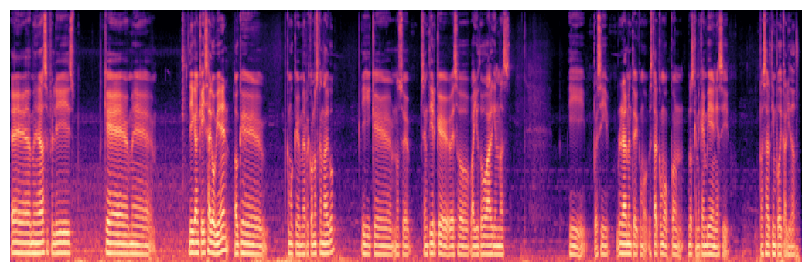

54/54 - 8s - loss: 0.0042 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - specificity: 1.0000 - 8s/epoch - 139ms/step


Training fold 1, epoch 1:   4%|▍         | 1/25 [00:19<07:55, 19.81s/it]

54/54 - 4s - loss: 3175.3765 - accuracy: 0.9259 - precision: 1.0000 - recall: 0.9259 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 4s/epoch - 80ms/step


Training fold 1, epoch 1:   8%|▊         | 2/25 [00:36<06:50, 17.83s/it]

54/54 - 4s - loss: 844.6577 - accuracy: 0.4444 - precision: 0.3636 - recall: 0.1481 - auc: 0.4420 - specificity: 0.6111 - 4s/epoch - 80ms/step


Training fold 1, epoch 1:  12%|█▏        | 3/25 [00:52<06:16, 17.13s/it]

54/54 - 4s - loss: 1.0723 - accuracy: 0.9537 - precision: 1.0000 - recall: 0.9537 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 4s/epoch - 81ms/step


Training fold 1, epoch 1:  16%|█▌        | 4/25 [01:08<05:53, 16.85s/it]

54/54 - 4s - loss: 24.9194 - accuracy: 0.4352 - precision: 0.4386 - recall: 0.4630 - auc: 0.4314 - specificity: 0.3333 - 4s/epoch - 78ms/step


Training fold 1, epoch 1:  20%|██        | 5/25 [01:25<05:33, 16.69s/it]

54/54 - 4s - loss: 9.1865 - accuracy: 0.5093 - precision: 0.5088 - recall: 0.5370 - auc: 0.4885 - specificity: 0.3519 - 4s/epoch - 78ms/step


Training fold 1, epoch 1:  24%|██▍       | 6/25 [01:41<05:15, 16.61s/it]

54/54 - 4s - loss: 7.9544 - accuracy: 0.4352 - precision: 0.4286 - recall: 0.3889 - auc: 0.4069 - specificity: 0.3889 - 4s/epoch - 79ms/step


Training fold 1, epoch 1:  28%|██▊       | 7/25 [01:58<04:58, 16.60s/it]

54/54 - 4s - loss: 0.0230 - accuracy: 0.9907 - precision: 1.0000 - recall: 0.9907 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 4s/epoch - 79ms/step


Training fold 1, epoch 1:  32%|███▏      | 8/25 [02:15<04:42, 16.61s/it]

54/54 - 4s - loss: 11.5547 - accuracy: 0.4815 - precision: 0.4828 - recall: 0.5185 - auc: 0.4823 - specificity: 0.3426 - 4s/epoch - 81ms/step


Training fold 1, epoch 1:  36%|███▌      | 9/25 [02:31<04:26, 16.68s/it]

54/54 - 4s - loss: 2.8977e-05 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - specificity: 1.0000 - 4s/epoch - 79ms/step


Training fold 1, epoch 1:  40%|████      | 10/25 [02:48<04:10, 16.72s/it]

54/54 - 4s - loss: 19.1482 - accuracy: 0.4259 - precision: 0.4200 - recall: 0.3889 - auc: 0.4180 - specificity: 0.4074 - 4s/epoch - 80ms/step


Training fold 1, epoch 1:  44%|████▍     | 11/25 [03:05<03:54, 16.77s/it]

54/54 - 4s - loss: 0.0026 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 4s/epoch - 81ms/step


Training fold 1, epoch 1:  48%|████▊     | 12/25 [03:22<03:39, 16.85s/it]

54/54 - 4s - loss: 5.3581e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 4s/epoch - 78ms/step


Training fold 1, epoch 1:  52%|█████▏    | 13/25 [03:39<03:22, 16.90s/it]

54/54 - 4s - loss: 10.4255 - accuracy: 0.4167 - precision: 0.4211 - recall: 0.4444 - auc: 0.4306 - specificity: 0.2963 - 4s/epoch - 80ms/step


Training fold 1, epoch 1:  56%|█████▌    | 14/25 [03:56<03:06, 16.98s/it]

54/54 - 4s - loss: 0.1029 - accuracy: 0.9722 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - specificity: 0.9722 - 4s/epoch - 80ms/step


Training fold 1, epoch 1:  60%|██████    | 15/25 [04:14<02:50, 17.08s/it]

54/54 - 4s - loss: 17.4314 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.4630 - auc: 0.4954 - specificity: 0.4167 - 4s/epoch - 80ms/step


Training fold 1, epoch 1:  64%|██████▍   | 16/25 [04:31<02:34, 17.19s/it]

54/54 - 4s - loss: 11.3579 - accuracy: 0.5556 - precision: 0.5556 - recall: 0.5556 - auc: 0.5219 - specificity: 0.4259 - 4s/epoch - 80ms/step


Training fold 1, epoch 1:  68%|██████▊   | 17/25 [04:48<02:18, 17.26s/it]

54/54 - 4s - loss: 3.6925e-07 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 4s/epoch - 80ms/step


Training fold 1, epoch 1:  72%|███████▏  | 18/25 [05:06<02:01, 17.38s/it]

54/54 - 4s - loss: 13.0637 - accuracy: 0.5741 - precision: 0.5769 - recall: 0.5556 - auc: 0.5460 - specificity: 0.4815 - 4s/epoch - 81ms/step


Training fold 1, epoch 1:  76%|███████▌  | 19/25 [05:24<01:44, 17.49s/it]

54/54 - 4s - loss: 0.4998 - accuracy: 0.9537 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - specificity: 0.9537 - 4s/epoch - 80ms/step


Training fold 1, epoch 1:  80%|████████  | 20/25 [05:42<01:28, 17.60s/it]

54/54 - 4s - loss: 15.7173 - accuracy: 0.4167 - precision: 0.4182 - recall: 0.4259 - auc: 0.4000 - specificity: 0.3241 - 4s/epoch - 77ms/step


Training fold 1, epoch 1:  84%|████████▍ | 21/25 [06:00<01:10, 17.66s/it]

54/54 - 4s - loss: 13.5559 - accuracy: 0.5556 - precision: 0.5600 - recall: 0.5185 - auc: 0.5424 - specificity: 0.4444 - 4s/epoch - 80ms/step


Training fold 1, epoch 1:  88%|████████▊ | 22/25 [06:18<00:53, 17.78s/it]

54/54 - 4s - loss: 8.7152 - accuracy: 0.3981 - precision: 0.4035 - recall: 0.4259 - auc: 0.3572 - specificity: 0.2685 - 4s/epoch - 82ms/step


Training fold 1, epoch 1:  92%|█████████▏| 23/25 [06:36<00:35, 17.93s/it]

54/54 - 4s - loss: 0.0085 - accuracy: 0.9907 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - specificity: 0.9907 - 4s/epoch - 81ms/step


Training fold 1, epoch 1:  96%|█████████▌| 24/25 [06:54<00:18, 18.07s/it]

27/27 - 3s - loss: 4.5878 - accuracy: 0.8889 - precision: 1.0000 - recall: 0.8889 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 3s/epoch - 102ms/step


Training fold 1, epoch 2:   0%|          | 0/25 [00:00<?, ?it/s]

54/54 - 4s - loss: 18.5649 - accuracy: 0.8611 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - specificity: 0.8611 - 4s/epoch - 79ms/step


Training fold 1, epoch 2:   4%|▍         | 1/25 [00:18<07:21, 18.42s/it]

54/54 - 4s - loss: 25.5911 - accuracy: 0.9259 - precision: 1.0000 - recall: 0.9259 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 4s/epoch - 81ms/step


Training fold 1, epoch 2:   8%|▊         | 2/25 [00:37<07:05, 18.52s/it]

54/54 - 4s - loss: 233.6877 - accuracy: 0.5185 - precision: 0.5179 - recall: 0.5370 - auc: 0.5291 - specificity: 0.3796 - 4s/epoch - 81ms/step


Training fold 1, epoch 2:  12%|█▏        | 3/25 [00:55<06:48, 18.58s/it]

54/54 - 4s - loss: 1.4939 - accuracy: 0.9352 - precision: 1.0000 - recall: 0.9352 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 4s/epoch - 80ms/step


Training fold 1, epoch 2:  16%|█▌        | 4/25 [01:14<06:30, 18.60s/it]

54/54 - 4s - loss: 31.6202 - accuracy: 0.4352 - precision: 0.4386 - recall: 0.4630 - auc: 0.4222 - specificity: 0.3241 - 4s/epoch - 82ms/step


Training fold 1, epoch 2:  20%|██        | 5/25 [01:33<06:14, 18.71s/it]

54/54 - 4s - loss: 14.4227 - accuracy: 0.4259 - precision: 0.4231 - recall: 0.4074 - auc: 0.3906 - specificity: 0.3519 - 4s/epoch - 82ms/step


Training fold 1, epoch 2:  24%|██▍       | 6/25 [01:52<05:57, 18.83s/it]

54/54 - 4s - loss: 14.9702 - accuracy: 0.4074 - precision: 0.4138 - recall: 0.4444 - auc: 0.3992 - specificity: 0.3056 - 4s/epoch - 81ms/step


Training fold 1, epoch 2:  28%|██▊       | 7/25 [02:11<05:40, 18.94s/it]

54/54 - 4s - loss: 0.3638 - accuracy: 0.9537 - precision: 1.0000 - recall: 0.9537 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 4s/epoch - 80ms/step


Training fold 1, epoch 2:  32%|███▏      | 8/25 [02:30<05:23, 19.03s/it]

54/54 - 4s - loss: 25.0407 - accuracy: 0.4074 - precision: 0.4074 - recall: 0.4074 - auc: 0.4263 - specificity: 0.3519 - 4s/epoch - 83ms/step


Training fold 1, epoch 2:  36%|███▌      | 9/25 [02:50<05:06, 19.15s/it]

54/54 - 4s - loss: 0.8608 - accuracy: 0.9167 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - specificity: 0.9167 - 4s/epoch - 81ms/step


Training fold 1, epoch 2:  40%|████      | 10/25 [03:09<04:48, 19.24s/it]

54/54 - 4s - loss: 46.2298 - accuracy: 0.4722 - precision: 0.4667 - recall: 0.3889 - auc: 0.4681 - specificity: 0.4630 - 4s/epoch - 79ms/step


Training fold 1, epoch 2:  44%|████▍     | 11/25 [03:29<04:30, 19.34s/it]

54/54 - 4s - loss: 7.1136e-12 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 4s/epoch - 81ms/step


Training fold 1, epoch 2:  48%|████▊     | 12/25 [03:48<04:13, 19.48s/it]

54/54 - 4s - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 4s/epoch - 80ms/step


Training fold 1, epoch 2:  52%|█████▏    | 13/25 [04:08<03:55, 19.65s/it]

54/54 - 4s - loss: 19.0067 - accuracy: 0.3889 - precision: 0.3929 - recall: 0.4074 - auc: 0.4055 - specificity: 0.3056 - 4s/epoch - 80ms/step


Training fold 1, epoch 2:  56%|█████▌    | 14/25 [04:30<03:43, 20.33s/it]

54/54 - 4s - loss: 1.0485 - accuracy: 0.9537 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - specificity: 0.9537 - 4s/epoch - 80ms/step


Training fold 1, epoch 2:  60%|██████    | 15/25 [04:50<03:22, 20.27s/it]

54/54 - 4s - loss: 37.8717 - accuracy: 0.3889 - precision: 0.3750 - recall: 0.3333 - auc: 0.3844 - specificity: 0.3333 - 4s/epoch - 81ms/step


Training fold 1, epoch 2:  64%|██████▍   | 16/25 [05:11<03:02, 20.28s/it]

54/54 - 4s - loss: 23.5020 - accuracy: 0.5185 - precision: 0.5185 - recall: 0.5185 - auc: 0.5010 - specificity: 0.3796 - 4s/epoch - 80ms/step


Training fold 1, epoch 2:  68%|██████▊   | 17/25 [05:31<02:42, 20.33s/it]

54/54 - 4s - loss: 1.2230 - accuracy: 0.9630 - precision: 1.0000 - recall: 0.9630 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 4s/epoch - 79ms/step


Training fold 1, epoch 2:  72%|███████▏  | 18/25 [05:52<02:22, 20.40s/it]

54/54 - 4s - loss: 42.9463 - accuracy: 0.4722 - precision: 0.4737 - recall: 0.5000 - auc: 0.4676 - specificity: 0.3333 - 4s/epoch - 80ms/step


Training fold 1, epoch 2:  76%|███████▌  | 19/25 [06:13<02:03, 20.54s/it]

54/54 - 4s - loss: 5.7379 - accuracy: 0.9074 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - specificity: 0.9074 - 4s/epoch - 80ms/step


Training fold 1, epoch 2:  80%|████████  | 20/25 [06:34<01:43, 20.68s/it]

54/54 - 4s - loss: 51.2306 - accuracy: 0.4259 - precision: 0.4091 - recall: 0.3333 - auc: 0.4280 - specificity: 0.4352 - 4s/epoch - 81ms/step


Training fold 1, epoch 2:  84%|████████▍ | 21/25 [06:55<01:23, 20.83s/it]

54/54 - 4s - loss: 15.5692 - accuracy: 0.3889 - precision: 0.3889 - recall: 0.3889 - auc: 0.3729 - specificity: 0.2685 - 4s/epoch - 80ms/step


Training fold 1, epoch 2:  88%|████████▊ | 22/25 [07:16<01:03, 21.01s/it]

54/54 - 4s - loss: 16.8053 - accuracy: 0.4352 - precision: 0.4364 - recall: 0.4444 - auc: 0.4431 - specificity: 0.2870 - 4s/epoch - 80ms/step


Training fold 1, epoch 2:  92%|█████████▏| 23/25 [07:38<00:42, 21.21s/it]

54/54 - 5s - loss: 3.7378 - accuracy: 0.9074 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - specificity: 0.9074 - 5s/epoch - 84ms/step


Training fold 1, epoch 2:  96%|█████████▌| 24/25 [08:00<00:21, 21.47s/it]

27/27 - 3s - loss: 77.7006 - accuracy: 0.6296 - precision: 1.0000 - recall: 0.6296 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 3s/epoch - 112ms/step


Training fold 1, epoch 3:   0%|          | 0/25 [00:00<?, ?it/s]

54/54 - 5s - loss: 84.6353 - accuracy: 0.7593 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - specificity: 0.7593 - 5s/epoch - 88ms/step


Training fold 1, epoch 3:   4%|▍         | 1/25 [00:23<09:31, 23.83s/it]

54/54 - 5s - loss: 67.6439 - accuracy: 0.9259 - precision: 1.0000 - recall: 0.9259 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 5s/epoch - 84ms/step


Training fold 1, epoch 3:   8%|▊         | 2/25 [00:46<08:58, 23.41s/it]

54/54 - 4s - loss: 410.9301 - accuracy: 0.4352 - precision: 0.4578 - recall: 0.7037 - auc: 0.4383 - specificity: 0.1389 - 4s/epoch - 82ms/step


Training fold 1, epoch 3:  12%|█▏        | 3/25 [01:09<08:29, 23.14s/it]

54/54 - 5s - loss: 0.6973 - accuracy: 0.9630 - precision: 1.0000 - recall: 0.9630 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 5s/epoch - 83ms/step


Training fold 1, epoch 3:  16%|█▌        | 4/25 [01:32<08:04, 23.07s/it]

54/54 - 5s - loss: 34.6738 - accuracy: 0.4815 - precision: 0.4828 - recall: 0.5185 - auc: 0.4854 - specificity: 0.3519 - 5s/epoch - 86ms/step


Training fold 1, epoch 3:  20%|██        | 5/25 [01:56<07:43, 23.15s/it]

54/54 - 5s - loss: 29.6725 - accuracy: 0.4630 - precision: 0.4655 - recall: 0.5000 - auc: 0.4412 - specificity: 0.3241 - 5s/epoch - 84ms/step


Training fold 1, epoch 3:  24%|██▍       | 6/25 [02:19<07:21, 23.26s/it]

54/54 - 5s - loss: 25.8140 - accuracy: 0.5093 - precision: 0.5094 - recall: 0.5000 - auc: 0.5146 - specificity: 0.3889 - 5s/epoch - 85ms/step


Training fold 1, epoch 3:  28%|██▊       | 7/25 [02:43<07:02, 23.45s/it]

54/54 - 5s - loss: 1.2860 - accuracy: 0.9444 - precision: 1.0000 - recall: 0.9444 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 5s/epoch - 84ms/step


Training fold 1, epoch 3:  32%|███▏      | 8/25 [03:07<06:40, 23.54s/it]

54/54 - 4s - loss: 28.2909 - accuracy: 0.5093 - precision: 0.5088 - recall: 0.5370 - auc: 0.5252 - specificity: 0.3611 - 4s/epoch - 80ms/step


Training fold 1, epoch 3:  36%|███▌      | 9/25 [03:30<06:17, 23.61s/it]

54/54 - 5s - loss: 0.5912 - accuracy: 0.9630 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - specificity: 0.9630 - 5s/epoch - 84ms/step


Training fold 1, epoch 3:  40%|████      | 10/25 [03:55<05:57, 23.85s/it]

54/54 - 5s - loss: 22.0429 - accuracy: 0.4815 - precision: 0.4792 - recall: 0.4259 - auc: 0.4803 - specificity: 0.3889 - 5s/epoch - 91ms/step


Training fold 1, epoch 3:  44%|████▍     | 11/25 [04:20<05:38, 24.17s/it]

54/54 - 4s - loss: 7.8635e-06 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 4s/epoch - 81ms/step


Training fold 1, epoch 3:  48%|████▊     | 12/25 [04:44<05:15, 24.25s/it]

54/54 - 4s - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 4s/epoch - 83ms/step


Training fold 1, epoch 3:  52%|█████▏    | 13/25 [05:09<04:51, 24.33s/it]

54/54 - 4s - loss: 40.6329 - accuracy: 0.3796 - precision: 0.3898 - recall: 0.4259 - auc: 0.3724 - specificity: 0.2407 - 4s/epoch - 83ms/step


Training fold 1, epoch 3:  56%|█████▌    | 14/25 [05:33<04:29, 24.46s/it]

54/54 - 5s - loss: 0.0026 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - specificity: 1.0000 - 5s/epoch - 85ms/step


Training fold 1, epoch 3:  60%|██████    | 15/25 [05:59<04:06, 24.69s/it]

54/54 - 4s - loss: 23.9627 - accuracy: 0.4815 - precision: 0.4800 - recall: 0.4444 - auc: 0.4947 - specificity: 0.4167 - 4s/epoch - 83ms/step


Training fold 1, epoch 3:  64%|██████▍   | 16/25 [06:24<03:43, 24.84s/it]

54/54 - 5s - loss: 20.4966 - accuracy: 0.4352 - precision: 0.4364 - recall: 0.4444 - auc: 0.4343 - specificity: 0.3148 - 5s/epoch - 85ms/step


Training fold 1, epoch 3:  68%|██████▊   | 17/25 [06:49<03:20, 25.04s/it]

54/54 - 4s - loss: 1.4032 - accuracy: 0.9537 - precision: 1.0000 - recall: 0.9537 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 4s/epoch - 82ms/step


Training fold 1, epoch 3:  72%|███████▏  | 18/25 [07:15<02:56, 25.17s/it]

54/54 - 5s - loss: 50.1826 - accuracy: 0.4907 - precision: 0.4918 - recall: 0.5556 - auc: 0.4861 - specificity: 0.3148 - 5s/epoch - 87ms/step


Training fold 1, epoch 3:  76%|███████▌  | 19/25 [07:41<02:32, 25.44s/it]

54/54 - 4s - loss: 0.0452 - accuracy: 0.9907 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - specificity: 0.9907 - 4s/epoch - 83ms/step


Training fold 1, epoch 3:  80%|████████  | 20/25 [08:08<02:09, 25.92s/it]

54/54 - 5s - loss: 19.2297 - accuracy: 0.4074 - precision: 0.4038 - recall: 0.3889 - auc: 0.3891 - specificity: 0.2778 - 5s/epoch - 84ms/step


Training fold 1, epoch 3:  84%|████████▍ | 21/25 [08:35<01:44, 26.19s/it]

54/54 - 5s - loss: 14.1852 - accuracy: 0.4907 - precision: 0.4902 - recall: 0.4630 - auc: 0.4631 - specificity: 0.3796 - 5s/epoch - 86ms/step


Training fold 1, epoch 3:  88%|████████▊ | 22/25 [09:01<01:19, 26.39s/it]

54/54 - 4s - loss: 23.9798 - accuracy: 0.4074 - precision: 0.4107 - recall: 0.4259 - auc: 0.3913 - specificity: 0.3148 - 4s/epoch - 81ms/step


Training fold 1, epoch 3:  92%|█████████▏| 23/25 [09:29<00:53, 26.62s/it]

54/54 - 5s - loss: 3.1937 - accuracy: 0.9167 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - specificity: 0.9167 - 5s/epoch - 85ms/step


Training fold 1, epoch 3:  96%|█████████▌| 24/25 [09:55<00:26, 26.59s/it]

27/27 - 3s - loss: 57.0803 - accuracy: 0.7222 - precision: 1.0000 - recall: 0.7222 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 3s/epoch - 99ms/step


Training fold 1, epoch 4:   0%|          | 0/25 [00:00<?, ?it/s]

54/54 - 5s - loss: 85.1224 - accuracy: 0.7778 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - specificity: 0.7778 - 5s/epoch - 84ms/step


Training fold 1, epoch 4:   4%|▍         | 1/25 [00:26<10:47, 26.97s/it]

54/54 - 5s - loss: 106.3961 - accuracy: 0.8519 - precision: 1.0000 - recall: 0.8519 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 5s/epoch - 88ms/step


Training fold 1, epoch 4:   8%|▊         | 2/25 [00:54<10:22, 27.06s/it]

54/54 - 5s - loss: 286.4594 - accuracy: 0.3611 - precision: 0.3729 - recall: 0.4074 - auc: 0.3563 - specificity: 0.2593 - 5s/epoch - 89ms/step


Training fold 1, epoch 4:  12%|█▏        | 3/25 [01:21<09:59, 27.27s/it]

54/54 - 5s - loss: 0.0259 - accuracy: 0.9907 - precision: 1.0000 - recall: 0.9907 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 5s/epoch - 83ms/step


Training fold 1, epoch 4:  16%|█▌        | 4/25 [01:48<09:32, 27.25s/it]

54/54 - 5s - loss: 34.7786 - accuracy: 0.4630 - precision: 0.4667 - recall: 0.5185 - auc: 0.4750 - specificity: 0.2963 - 5s/epoch - 87ms/step


Training fold 1, epoch 4:  20%|██        | 5/25 [02:16<09:07, 27.38s/it]

54/54 - 5s - loss: 17.0614 - accuracy: 0.4444 - precision: 0.4400 - recall: 0.4074 - auc: 0.4496 - specificity: 0.3426 - 5s/epoch - 89ms/step


Training fold 1, epoch 4:  24%|██▍       | 6/25 [02:44<08:44, 27.59s/it]

54/54 - 5s - loss: 18.6011 - accuracy: 0.4352 - precision: 0.4407 - recall: 0.4815 - auc: 0.4016 - specificity: 0.2500 - 5s/epoch - 84ms/step


Training fold 1, epoch 4:  28%|██▊       | 7/25 [03:12<08:17, 27.64s/it]

54/54 - 5s - loss: 0.6081 - accuracy: 0.9444 - precision: 1.0000 - recall: 0.9444 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 5s/epoch - 88ms/step


Training fold 1, epoch 4:  32%|███▏      | 8/25 [03:40<07:52, 27.80s/it]

54/54 - 5s - loss: 20.3371 - accuracy: 0.5185 - precision: 0.5172 - recall: 0.5556 - auc: 0.5345 - specificity: 0.3426 - 5s/epoch - 86ms/step


Training fold 1, epoch 4:  36%|███▌      | 9/25 [04:08<07:27, 27.97s/it]

54/54 - 5s - loss: 0.4833 - accuracy: 0.9815 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - specificity: 0.9815 - 5s/epoch - 86ms/step


Training fold 1, epoch 4:  40%|████      | 10/25 [04:37<07:02, 28.13s/it]

54/54 - 5s - loss: 23.3763 - accuracy: 0.4537 - precision: 0.4468 - recall: 0.3889 - auc: 0.4419 - specificity: 0.3981 - 5s/epoch - 89ms/step


Training fold 1, epoch 4:  44%|████▍     | 11/25 [05:06<06:39, 28.51s/it]

54/54 - 5s - loss: 0.0821 - accuracy: 0.9907 - precision: 1.0000 - recall: 0.9907 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 5s/epoch - 86ms/step


Training fold 1, epoch 4:  48%|████▊     | 12/25 [05:35<06:14, 28.78s/it]

54/54 - 5s - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 5s/epoch - 91ms/step


Training fold 1, epoch 4:  52%|█████▏    | 13/25 [06:05<05:49, 29.14s/it]

54/54 - 5s - loss: 31.6861 - accuracy: 0.5278 - precision: 0.5246 - recall: 0.5926 - auc: 0.5132 - specificity: 0.3611 - 5s/epoch - 86ms/step


Training fold 1, epoch 4:  56%|█████▌    | 14/25 [06:35<05:21, 29.26s/it]

54/54 - 5s - loss: 0.1240 - accuracy: 0.9907 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - specificity: 0.9907 - 5s/epoch - 89ms/step


Training fold 1, epoch 4:  60%|██████    | 15/25 [07:05<04:55, 29.56s/it]

54/54 - 4s - loss: 28.7845 - accuracy: 0.4630 - precision: 0.4565 - recall: 0.3889 - auc: 0.4755 - specificity: 0.3981 - 4s/epoch - 83ms/step


Training fold 1, epoch 4:  64%|██████▍   | 16/25 [07:35<04:26, 29.61s/it]

54/54 - 5s - loss: 21.7212 - accuracy: 0.3519 - precision: 0.3571 - recall: 0.3704 - auc: 0.3270 - specificity: 0.3056 - 5s/epoch - 86ms/step


Training fold 1, epoch 4:  68%|██████▊   | 17/25 [08:05<03:57, 29.74s/it]

54/54 - 5s - loss: 7.9705e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 5s/epoch - 85ms/step


Training fold 1, epoch 4:  72%|███████▏  | 18/25 [08:35<03:28, 29.85s/it]

54/54 - 5s - loss: 31.2726 - accuracy: 0.4537 - precision: 0.4561 - recall: 0.4815 - auc: 0.4530 - specificity: 0.3611 - 5s/epoch - 88ms/step


Training fold 1, epoch 4:  76%|███████▌  | 19/25 [09:06<03:00, 30.05s/it]

54/54 - 5s - loss: 0.8901 - accuracy: 0.9537 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - specificity: 0.9537 - 5s/epoch - 84ms/step


Training fold 1, epoch 4:  80%|████████  | 20/25 [09:36<02:30, 30.11s/it]

54/54 - 5s - loss: 31.0020 - accuracy: 0.4815 - precision: 0.4815 - recall: 0.4815 - auc: 0.4856 - specificity: 0.3796 - 5s/epoch - 89ms/step


Training fold 1, epoch 4:  84%|████████▍ | 21/25 [10:07<02:01, 30.40s/it]

54/54 - 4s - loss: 15.0665 - accuracy: 0.3333 - precision: 0.3333 - recall: 0.3333 - auc: 0.3448 - specificity: 0.2685 - 4s/epoch - 81ms/step


Training fold 1, epoch 4:  88%|████████▊ | 22/25 [10:38<01:31, 30.47s/it]

54/54 - 5s - loss: 14.9169 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.3889 - auc: 0.4880 - specificity: 0.4537 - 5s/epoch - 86ms/step


Training fold 1, epoch 4:  92%|█████████▏| 23/25 [11:09<01:01, 30.77s/it]

54/54 - 5s - loss: 7.4132 - accuracy: 0.8426 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - specificity: 0.8426 - 5s/epoch - 86ms/step


Training fold 1, epoch 4:  96%|█████████▌| 24/25 [11:41<00:31, 31.06s/it]

27/27 - 3s - loss: 62.5891 - accuracy: 0.5926 - precision: 1.0000 - recall: 0.5926 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 3s/epoch - 95ms/step


Training fold 1, epoch 5:   0%|          | 0/25 [00:00<?, ?it/s]

54/54 - 5s - loss: 28.2568 - accuracy: 0.8704 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - specificity: 0.8704 - 5s/epoch - 84ms/step


Training fold 1, epoch 5:   4%|▍         | 1/25 [00:31<12:41, 31.74s/it]

54/54 - 5s - loss: 245.2305 - accuracy: 0.8519 - precision: 1.0000 - recall: 0.8519 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 5s/epoch - 89ms/step


Training fold 1, epoch 5:   8%|▊         | 2/25 [01:03<12:16, 32.03s/it]

54/54 - 5s - loss: 47.4451 - accuracy: 0.3981 - precision: 0.4068 - recall: 0.4444 - auc: 0.3981 - specificity: 0.2778 - 5s/epoch - 84ms/step


Training fold 1, epoch 5:  12%|█▏        | 3/25 [01:36<11:45, 32.07s/it]

54/54 - 5s - loss: 0.0254 - accuracy: 0.9907 - precision: 1.0000 - recall: 0.9907 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 5s/epoch - 84ms/step


Training fold 1, epoch 5:  16%|█▌        | 4/25 [02:08<11:14, 32.12s/it]

54/54 - 5s - loss: 20.2122 - accuracy: 0.4074 - precision: 0.4107 - recall: 0.4259 - auc: 0.4019 - specificity: 0.2963 - 5s/epoch - 85ms/step


Training fold 1, epoch 5:  20%|██        | 5/25 [02:40<10:44, 32.23s/it]

54/54 - 5s - loss: 12.3327 - accuracy: 0.3611 - precision: 0.3529 - recall: 0.3333 - auc: 0.3721 - specificity: 0.3148 - 5s/epoch - 85ms/step


Training fold 1, epoch 5:  24%|██▍       | 6/25 [03:12<10:11, 32.21s/it]

54/54 - 5s - loss: 12.3123 - accuracy: 0.5370 - precision: 0.5370 - recall: 0.5370 - auc: 0.5266 - specificity: 0.3889 - 5s/epoch - 88ms/step


Training fold 1, epoch 5:  28%|██▊       | 7/25 [03:45<09:42, 32.38s/it]

54/54 - 5s - loss: 0.5172 - accuracy: 0.9722 - precision: 1.0000 - recall: 0.9722 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 5s/epoch - 100ms/step


Training fold 1, epoch 5:  32%|███▏      | 8/25 [04:19<09:16, 32.76s/it]

54/54 - 5s - loss: 26.5290 - accuracy: 0.3889 - precision: 0.3966 - recall: 0.4259 - auc: 0.3719 - specificity: 0.2870 - 5s/epoch - 85ms/step


Training fold 1, epoch 5:  36%|███▌      | 9/25 [04:51<08:44, 32.75s/it]

54/54 - 5s - loss: 0.9682 - accuracy: 0.9352 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - specificity: 0.9352 - 5s/epoch - 89ms/step


Training fold 1, epoch 5:  40%|████      | 10/25 [05:25<08:14, 32.94s/it]

54/54 - 5s - loss: 14.7165 - accuracy: 0.4630 - precision: 0.4600 - recall: 0.4259 - auc: 0.4546 - specificity: 0.3889 - 5s/epoch - 85ms/step


Training fold 1, epoch 5:  44%|████▍     | 11/25 [05:58<07:42, 33.04s/it]

54/54 - 5s - loss: 0.2260 - accuracy: 0.9815 - precision: 1.0000 - recall: 0.9815 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 5s/epoch - 87ms/step


Training fold 1, epoch 5:  48%|████▊     | 12/25 [06:32<07:11, 33.18s/it]

54/54 - 5s - loss: 3.4035e-15 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 5s/epoch - 86ms/step


Training fold 1, epoch 5:  52%|█████▏    | 13/25 [07:05<06:40, 33.38s/it]

54/54 - 5s - loss: 12.0311 - accuracy: 0.4444 - precision: 0.4500 - recall: 0.5000 - auc: 0.4263 - specificity: 0.3056 - 5s/epoch - 91ms/step


Training fold 1, epoch 5:  56%|█████▌    | 14/25 [07:40<06:12, 33.89s/it]

54/54 - 5s - loss: 2.9088e-13 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - specificity: 1.0000 - 5s/epoch - 87ms/step


Training fold 1, epoch 5:  60%|██████    | 15/25 [08:15<05:41, 34.18s/it]

54/54 - 5s - loss: 12.8368 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.4444 - auc: 0.4955 - specificity: 0.4074 - 5s/epoch - 86ms/step


Training fold 1, epoch 5:  64%|██████▍   | 16/25 [08:50<05:08, 34.29s/it]

54/54 - 4s - loss: 10.9501 - accuracy: 0.4074 - precision: 0.4194 - recall: 0.4815 - auc: 0.3729 - specificity: 0.2778 - 4s/epoch - 82ms/step


Training fold 1, epoch 5:  68%|██████▊   | 17/25 [09:24<04:34, 34.36s/it]

54/54 - 5s - loss: 1.5843 - accuracy: 0.9074 - precision: 1.0000 - recall: 0.9074 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 5s/epoch - 92ms/step


Training fold 1, epoch 5:  72%|███████▏  | 18/25 [10:00<04:03, 34.72s/it]

54/54 - 5s - loss: 19.5189 - accuracy: 0.4074 - precision: 0.4138 - recall: 0.4444 - auc: 0.3831 - specificity: 0.3148 - 5s/epoch - 84ms/step


Training fold 1, epoch 5:  76%|███████▌  | 19/25 [10:35<03:29, 34.87s/it]

54/54 - 5s - loss: 1.1290 - accuracy: 0.9444 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - specificity: 0.9444 - 5s/epoch - 85ms/step


Training fold 1, epoch 5:  80%|████████  | 20/25 [11:11<02:55, 35.07s/it]

54/54 - 5s - loss: 21.0264 - accuracy: 0.4352 - precision: 0.4286 - recall: 0.3889 - auc: 0.3889 - specificity: 0.3889 - 5s/epoch - 86ms/step


Training fold 1, epoch 5:  84%|████████▍ | 21/25 [11:46<02:21, 35.25s/it]

54/54 - 5s - loss: 11.2490 - accuracy: 0.3426 - precision: 0.3509 - recall: 0.3704 - auc: 0.3373 - specificity: 0.2500 - 5s/epoch - 91ms/step


Training fold 1, epoch 5:  88%|████████▊ | 22/25 [12:23<01:46, 35.62s/it]

54/54 - 5s - loss: 9.3357 - accuracy: 0.3611 - precision: 0.3469 - recall: 0.3148 - auc: 0.3539 - specificity: 0.3056 - 5s/epoch - 84ms/step


Training fold 1, epoch 5:  92%|█████████▏| 23/25 [12:59<01:11, 35.64s/it]

54/54 - 5s - loss: 0.9641 - accuracy: 0.9259 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - specificity: 0.9259 - 5s/epoch - 84ms/step


Training fold 1, epoch 5:  96%|█████████▌| 24/25 [13:35<00:35, 35.79s/it]

27/27 - 3s - loss: 10.3337 - accuracy: 0.7407 - precision: 1.0000 - recall: 0.7407 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 3s/epoch - 102ms/step


Training fold 1, epoch 6:   0%|          | 0/25 [00:00<?, ?it/s]

54/54 - 5s - loss: 15.9269 - accuracy: 0.7870 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - specificity: 0.7870 - 5s/epoch - 87ms/step


Training fold 1, epoch 6:   4%|▍         | 1/25 [00:37<14:50, 37.10s/it]

54/54 - 5s - loss: 7.9850 - accuracy: 0.9259 - precision: 1.0000 - recall: 0.9259 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 5s/epoch - 85ms/step


Training fold 1, epoch 6:   8%|▊         | 2/25 [01:13<14:06, 36.82s/it]

54/54 - 6s - loss: 149.1198 - accuracy: 0.4167 - precision: 0.4211 - recall: 0.4444 - auc: 0.4120 - specificity: 0.3241 - 6s/epoch - 104ms/step


Training fold 1, epoch 6:  12%|█▏        | 3/25 [01:51<13:42, 37.40s/it]

54/54 - 5s - loss: 0.8700 - accuracy: 0.9537 - precision: 1.0000 - recall: 0.9537 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 5s/epoch - 85ms/step


Training fold 1, epoch 6:  16%|█▌        | 4/25 [02:29<13:06, 37.44s/it]

54/54 - 5s - loss: 14.5413 - accuracy: 0.4815 - precision: 0.4839 - recall: 0.5556 - auc: 0.4568 - specificity: 0.2963 - 5s/epoch - 84ms/step


Training fold 1, epoch 6:  20%|██        | 5/25 [03:06<12:27, 37.39s/it]

54/54 - 5s - loss: 7.1514 - accuracy: 0.4444 - precision: 0.4375 - recall: 0.3889 - auc: 0.4647 - specificity: 0.3981 - 5s/epoch - 84ms/step


Training fold 1, epoch 6:  24%|██▍       | 6/25 [03:44<11:51, 37.46s/it]

54/54 - 5s - loss: 6.0495 - accuracy: 0.4352 - precision: 0.4340 - recall: 0.4259 - auc: 0.4088 - specificity: 0.3611 - 5s/epoch - 91ms/step


Training fold 1, epoch 6:  28%|██▊       | 7/25 [04:22<11:21, 37.84s/it]

54/54 - 5s - loss: 0.0469 - accuracy: 0.9815 - precision: 1.0000 - recall: 0.9815 - auc: 0.0000e+00 - specificity: 0.0000e+00 - 5s/epoch - 86ms/step


Training fold 1, epoch 6:  32%|███▏      | 8/25 [05:00<10:44, 37.90s/it]

54/54 - 5s - loss: 11.0497 - accuracy: 0.4352 - precision: 0.4426 - recall: 0.5000 - auc: 0.4160 - specificity: 0.3056 - 5s/epoch - 91ms/step


Training fold 1, epoch 6:  36%|███▌      | 9/25 [06:04<10:48, 40.52s/it]


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

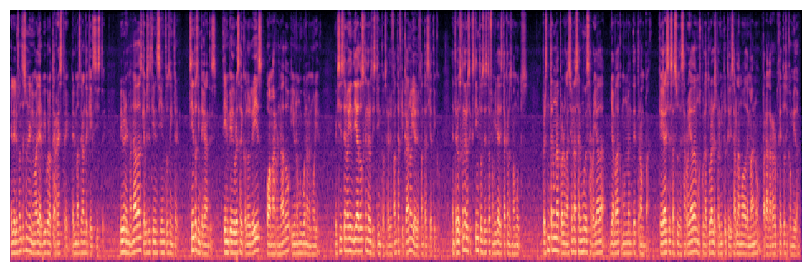

In [8]:
tester = KFoldCNNTester(data_dict_loaded, 'results', batch_size=2)

# Run the K-Fold test
tester.run_kfold_test()
